In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Optimisation with Stochastic Gradient Descent

The reaction rates of the circuits can be directly optimised with the automatic differentiation provided by jax

In [24]:
from datetime import datetime 
import jax 
import jax.numpy as jnp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optax
from scipy.special import factorial
import diffrax as dfx
from functools import partial
from bioreaction.misc.misc import flatten_listlike
from synbio_morpher.utils.results.analytics.timeseries import get_sensitivity, get_precision, get_peaks

jax.config.update('jax_platform_name', 'gpu')

rng = jax.random.PRNGKey(0)

np.random.seed(0)


In [25]:
def processor(input, funcs):
    for func in funcs:
        if type(input) == tuple:
            input = func(*input)
        else:
            input = func(input)
    return input


In [26]:
def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


# ODE Terms
def bioreaction_sim_expanded(t, y,
                             args,
                             inputs, outputs,
                             #  signal, signal_onehot: jnp.ndarray,
                             forward_rates=None, reverse_rates=None):
    return one_step_de_sim_expanded(
        spec_conc=y, inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        reverse_rates=reverse_rates)  # + signal(t) * signal_onehot


def bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                 inputs, outputs, forward_rates, reverse_rates,
                                 solver=dfx.Tsit5(),
                                 saveat=dfx.SaveAt(
                                     t0=True, t1=True, steps=True),
                                 max_steps=16**5,
                                 stepsize_controller=dfx.ConstantStepSize()):
    term = dfx.ODETerm(
        partial(bioreaction_sim_expanded,
                inputs=inputs, outputs=outputs,
                forward_rates=forward_rates.squeeze(), reverse_rates=reverse_rates.squeeze()
                )
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=dt0,
                           y0=y0.squeeze(),
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=stepsize_controller)


def f(reverse_rates, y0, t0, t1, dt0,
      inputs, outputs, forward_rates):
    s = bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                     inputs, outputs, forward_rates, reverse_rates,
                                     saveat=dfx.SaveAt(ts=np.linspace(t0, t1, 100)))
    ys = s.ys
    # ys = s.ys[:np.argmax(s.ts >= np.inf), :]
    # ts = s.ts[:np.argmax(s.ts >= np.inf)]

    return ys


def f2(eqconstants_exps, y0, t0, t1, dt0,
       inputs, outputs, forward_rates):
    
    eqconstants = jnp.power(10, eqconstants_exps)
    reverse_rates = forward_rates / eqconstants
    s = bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                     inputs, outputs, forward_rates, reverse_rates,
                                     saveat=dfx.SaveAt(ts=np.linspace(t0, t1, 100)))
    ys = s.ys
    return ys


def cost_f(ys, signal_idx, output_idxs):
    peaks = get_peaks(ys[0, :], ys[-1, :], jnp.max(ys, axis=0), jnp.min(ys, axis=0))
    sens = get_sensitivity(signal_idx=signal_idx,
                           starting_states=ys[0, :], peaks=peaks)
    cost = -jnp.prod(sens[output_idxs])
    return cost

## Define parameters

Creating a toy (RNA) circuit. The $k_1$ is the association binding rate (molecule / sec) for RNA binding, expanded for every binding reaction into `forward_rates`, and is assumed to be the same for all RNA. The equilibrium constants are randomly generated and define the circuit. From this and $k_1$, the reverse rate is calculated.

In [27]:
n_species = 3
n_circuits = 100
n_reactions = np.sum(np.arange(n_species+1))
tot_species = n_species + n_reactions

signal_idxs = np.array([0])
output_idxs = np.array([1, 2])
signal_onehot = np.zeros(tot_species)
signal_onehot[signal_idxs] = 1
signal_target = 2

y0 = np.array([200.0] * n_species + [0.0] * n_reactions) 
k1 = 0.00150958097
t0, t1, dt0 = 0, 20, 0.001

inputs, outputs = np.zeros((n_reactions, tot_species)), np.zeros(
    (n_reactions, tot_species))
inds = flatten_listlike([[(i, j) for j in range(i, n_species)]
                        for i in range(n_species)])

for i in range(n_reactions):
    inputs[i, inds[i][0]] += 1
    inputs[i, inds[i][1]] += 1
    outputs[i, i+n_species] += 1
    
forward_rates = np.ones(n_reactions) * k1
# eqconstants = np.power(10, np.random.normal(0, 1, (n_circuits, n_reactions)))
eqconstants_exps = (np.random.rand(n_circuits, n_reactions) - 0.5) / 10
eqconstants = np.power(10, eqconstants_exps)
reverse_rates = k1 / eqconstants


<Axes: ylabel='Count'>

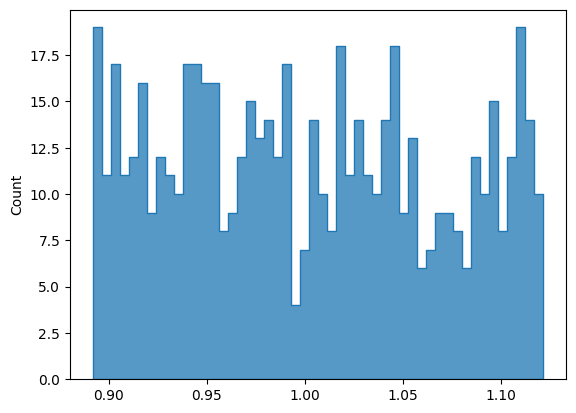

In [28]:
sns.histplot(eqconstants.flatten(), bins=50, element='step')

### Steady states + perturbation

Run the simulation once with starting states for the RNA molecules and their bound-together states. Use the steady states from that as the starting states for the optimisation simulation. Because we are (for now) trying to optimise for circuits that are very sensitive to a signal, we can perturb these starting states with a signal.

In [29]:
def f_simstep(circuit_params, y0, f, signal_onehot, signal_target):
    y_steady = f(circuit_params, y0)
    y_perturbed = y_steady[-1, :] * (signal_onehot == 0) + \
        y_steady[-1, :] * (signal_onehot == 1) * signal_target
    return y_steady, y_perturbed


def sim_wrapper(circuit_params, yp, y0, f_t):
    ys = f_t(circuit_params, yp)
    return jnp.concatenate([y0, ys], axis=0)


f_t = partial(f2, t0=t0, t1=t1, dt0=dt0, inputs=inputs,
              outputs=outputs, forward_rates=forward_rates)
f_simstep_t = partial(
    f_simstep, f=f_t, signal_onehot=signal_onehot, signal_target=signal_target)
c_t = partial(cost_f, signal_idx=signal_idxs, output_idxs=output_idxs)
sim_chain = [partial(sim_wrapper, f_t=f_t), c_t]
f_full = partial(processor, funcs=sim_chain)

y_steady, y_perturbed = jax.vmap(f_simstep_t)(
    eqconstants_exps, y0=np.repeat(y0[None, :], repeats=n_circuits, axis=0))

In [30]:
y_steady[:10].max(axis=1).shape

(10, 9)

We are starting all of the circuits off in a very similar state by initialising a random set of binding rates, equilibrium constants, or the exponents of the equiliribum constants for the RNA binding reactions. These are the circuit parameters that we are actually differentiating over. We want all our circuits to start off in a relatively similar state but still have some variation, so that we aren't accidentally starting out all circuits in a part of the network design space where each one sits in a local minima already. 

Below is a graph of the signal sensitivity for all our randomly generated circuits.

<Axes: >

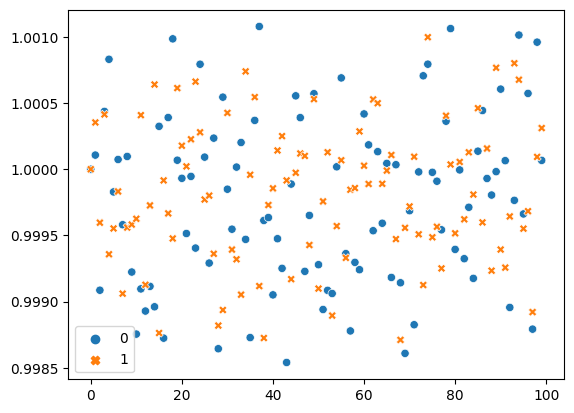

In [31]:
sns.scatterplot(get_sensitivity(signal_idx=signal_idxs, starting_states=y_steady[:, 1, :], peaks=get_peaks(y_steady[:, 0, :], y_steady[:, -1, :], y_steady.max(axis=1), y_steady.min(axis=1)))[:, output_idxs])

In [32]:
# Test it
cost = jax.vmap(f_full)((eqconstants_exps, y_perturbed, y_steady[:, -1, :][:, None, :]))
cost


Array([-0.0766388 , -0.07821632, -0.07183721, -0.07883776, -0.07942126,
       -0.0751081 , -0.07577661, -0.07162564, -0.07643563, -0.07350865,
       -0.07206445, -0.07438938, -0.06795177, -0.07385994, -0.07561901,
       -0.07429173, -0.07177574, -0.07650048, -0.07945284, -0.0787641 ,
       -0.07640985, -0.07680771, -0.07919363, -0.07659224, -0.08111944,
       -0.07769709, -0.0727279 , -0.07388556, -0.06721272, -0.07480656,
       -0.0791118 , -0.07246095, -0.07460852, -0.07580053, -0.07986762,
       -0.07081612, -0.08165497, -0.0787004 , -0.06950086, -0.0757322 ,
       -0.07229755, -0.07632332, -0.07359873, -0.07044771, -0.07286751,
       -0.07776207, -0.07747944, -0.07498544, -0.07350555, -0.08278364,
       -0.06960427, -0.07337877, -0.07556903, -0.06830237, -0.076051  ,
       -0.08162293, -0.07273102, -0.07205977, -0.0728396 , -0.07522336,
       -0.07945143, -0.07646935, -0.07687913, -0.0793872 , -0.0732941 ,
       -0.0791117 , -0.07555225, -0.07540395, -0.06971575, -0.07

# Simulate

Optimiser and learning rate management

In [33]:
l2_reg_alpha = 0.1
learning_rate = 0.1
warmup_epochs = 19
epochs = 20
n_batches = 1
warmup_fn = optax.linear_schedule(
    init_value=0., end_value=learning_rate,
    transition_steps=warmup_epochs * n_batches)
cosine_epochs = max(epochs - warmup_epochs, 1)
cosine_fn = optax.cosine_decay_schedule(
    init_value=0.01, decay_steps=1000) #, alpha=l2_reg_alpha)
schedule_fn = optax.join_schedules(
    schedules=[warmup_fn, cosine_fn],
    boundaries=[warmup_epochs * n_batches, cosine_epochs * n_batches])
optimiser = optax.sgd(learning_rate=schedule_fn)
optimiser_state = optimiser.init(reverse_rates[0])

Core function to iterate over. The automatic differentiation is enacted by the function `jax.value_and_grad` and can only evaluate a function that returns a scalar input. In order to do this for all of our samples, we can wrap it in the vectorisation function `jax.vmap`. The inputs are then the parameters of the circuit (either the equilibrium constant or the reverse rates, depending on what we're testing), along with the previously computed starting states (`y_steady_states`) and the perturbed signal state (`y_perturbed`). We need both in order to calculate the sensitivity after simulating the time series for all of our circuits, from which we calculate the cost function. Unfortunately, we can't vmap these two input parameters because they differ for each circuit. The updates are then applied to the circuit parameters with the `optax` library. 

In [34]:
def f_scan(inp, cr, f, fsim, y0):
    c, r = cr
    circuit_params, optimiser_state = inp
    
    y0, yp = jax.vmap(fsim)(circuit_params, y0)
    y0 = y0[:, -1, :][:, None, :]
    
    c, grads = jax.vmap(jax.value_and_grad(f, argnums=0))((circuit_params, yp, y0))
    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    
    circuit_params = optax.apply_updates(circuit_params, updates[0])
    
    # new_circuit_params = optax.apply_updates(circuit_params, updates[0])
    # Slow down gradient if negatives appear
    # new_circuit_params = jnp.where(new_circuit_params <= 0, optax.apply_updates(circuit_params, 0.01 * updates[0]), new_circuit_params)
    # circuit_params = jnp.where(new_circuit_params <= 0, circuit_params / 10, new_circuit_params)
    return [circuit_params, optimiser_state], [c, circuit_params]

cs = np.zeros([epochs, n_circuits])
rs = np.zeros([epochs, *eqconstants.shape])

### Run simulation

In [35]:
# 3 mins
print('Predicted time:', 17.5/30 * epochs, 'mins')

start_time = datetime.now()
ro, crs = jax.lax.scan(partial(f_scan, f=f_full, fsim=f_simstep_t,
                       y0=y_steady[:, -1, :][:, None, :]), init=[eqconstants_exps, optimiser_state], xs=[cs, rs])
print('Time:', datetime.now() - start_time)

all_eqconstants = np.concatenate([eqconstants_exps[None, :, :], np.zeros_like(rs)])
fin_eqconstants, optimiser_state = ro
cs, all_eqconstants1 = crs
all_eqconstants[1:] = all_eqconstants1

Predicted time: 11.666666666666668 mins


Costs over all epochs:

In [ ]:
cs

Array([[-0.00933226, -0.00969134, -0.00837637, ..., -0.00778508,
        -0.01044266, -0.00977106],
       [-0.00933226, -0.00969134, -0.00837637, ..., -0.00778508,
        -0.01044266, -0.00977106],
       [-0.00938064, -0.00974266, -0.00841794, ..., -0.00782235,
        -0.01049798, -0.00982224],
       ...,
       [-0.01013734, -0.01054366, -0.00907407, ..., -0.00841069,
        -0.01135896, -0.01062048],
       [-0.01016358, -0.01057153, -0.00909706, ..., -0.00843138,
        -0.01138881, -0.01064805],
       [-0.01018968, -0.01059928, -0.00912015, ..., -0.00845205,
        -0.01141873, -0.01067566]], dtype=float32)

Circuit parameters over all epochs:

In [ ]:
np.power(10, all_eqconstants[-1])

array([[1.00571415, 1.06726027, 1.04029596, 1.04831242, 1.02032629,
        1.07200686],
       [0.98001725, 1.11161671, 1.12950917, 1.01282354, 1.1086956 ,
        1.0452854 ],
       [1.01073986, 1.11787154, 0.92056362, 0.94328286, 0.92926413,
        1.11395183],
       [1.06030365, 1.10630909, 1.13383652, 1.1113984 , 1.03090873,
        1.10662804],
       [0.91038   , 1.04904024, 0.93830095, 1.14546835, 1.04346629,
        1.01996015],
       [0.94189371, 1.08095504, 1.0057013 , 1.05216569, 0.93106459,
        1.06394737],
       [1.02058474, 1.04343371, 1.12395689, 1.08020354, 1.00551144,
        1.02314751],
       [1.04153416, 0.9182252 , 1.05389681, 1.0741275 , 0.96927816,
        0.95189181],
       [0.95295964, 0.98503229, 1.03252252, 1.02275874, 1.15646381,
        0.94947764],
       [0.93010748, 0.9399359 , 1.05099148, 0.9793666 , 1.02697925,
        0.9773664 ],
       [0.91962142, 0.92866657, 1.05124739, 0.95349055, 0.96588893,
        1.00361879],
       [1.07144136, 0

# Visualise

Let's see what kind of behavior the trained network is now giving us:

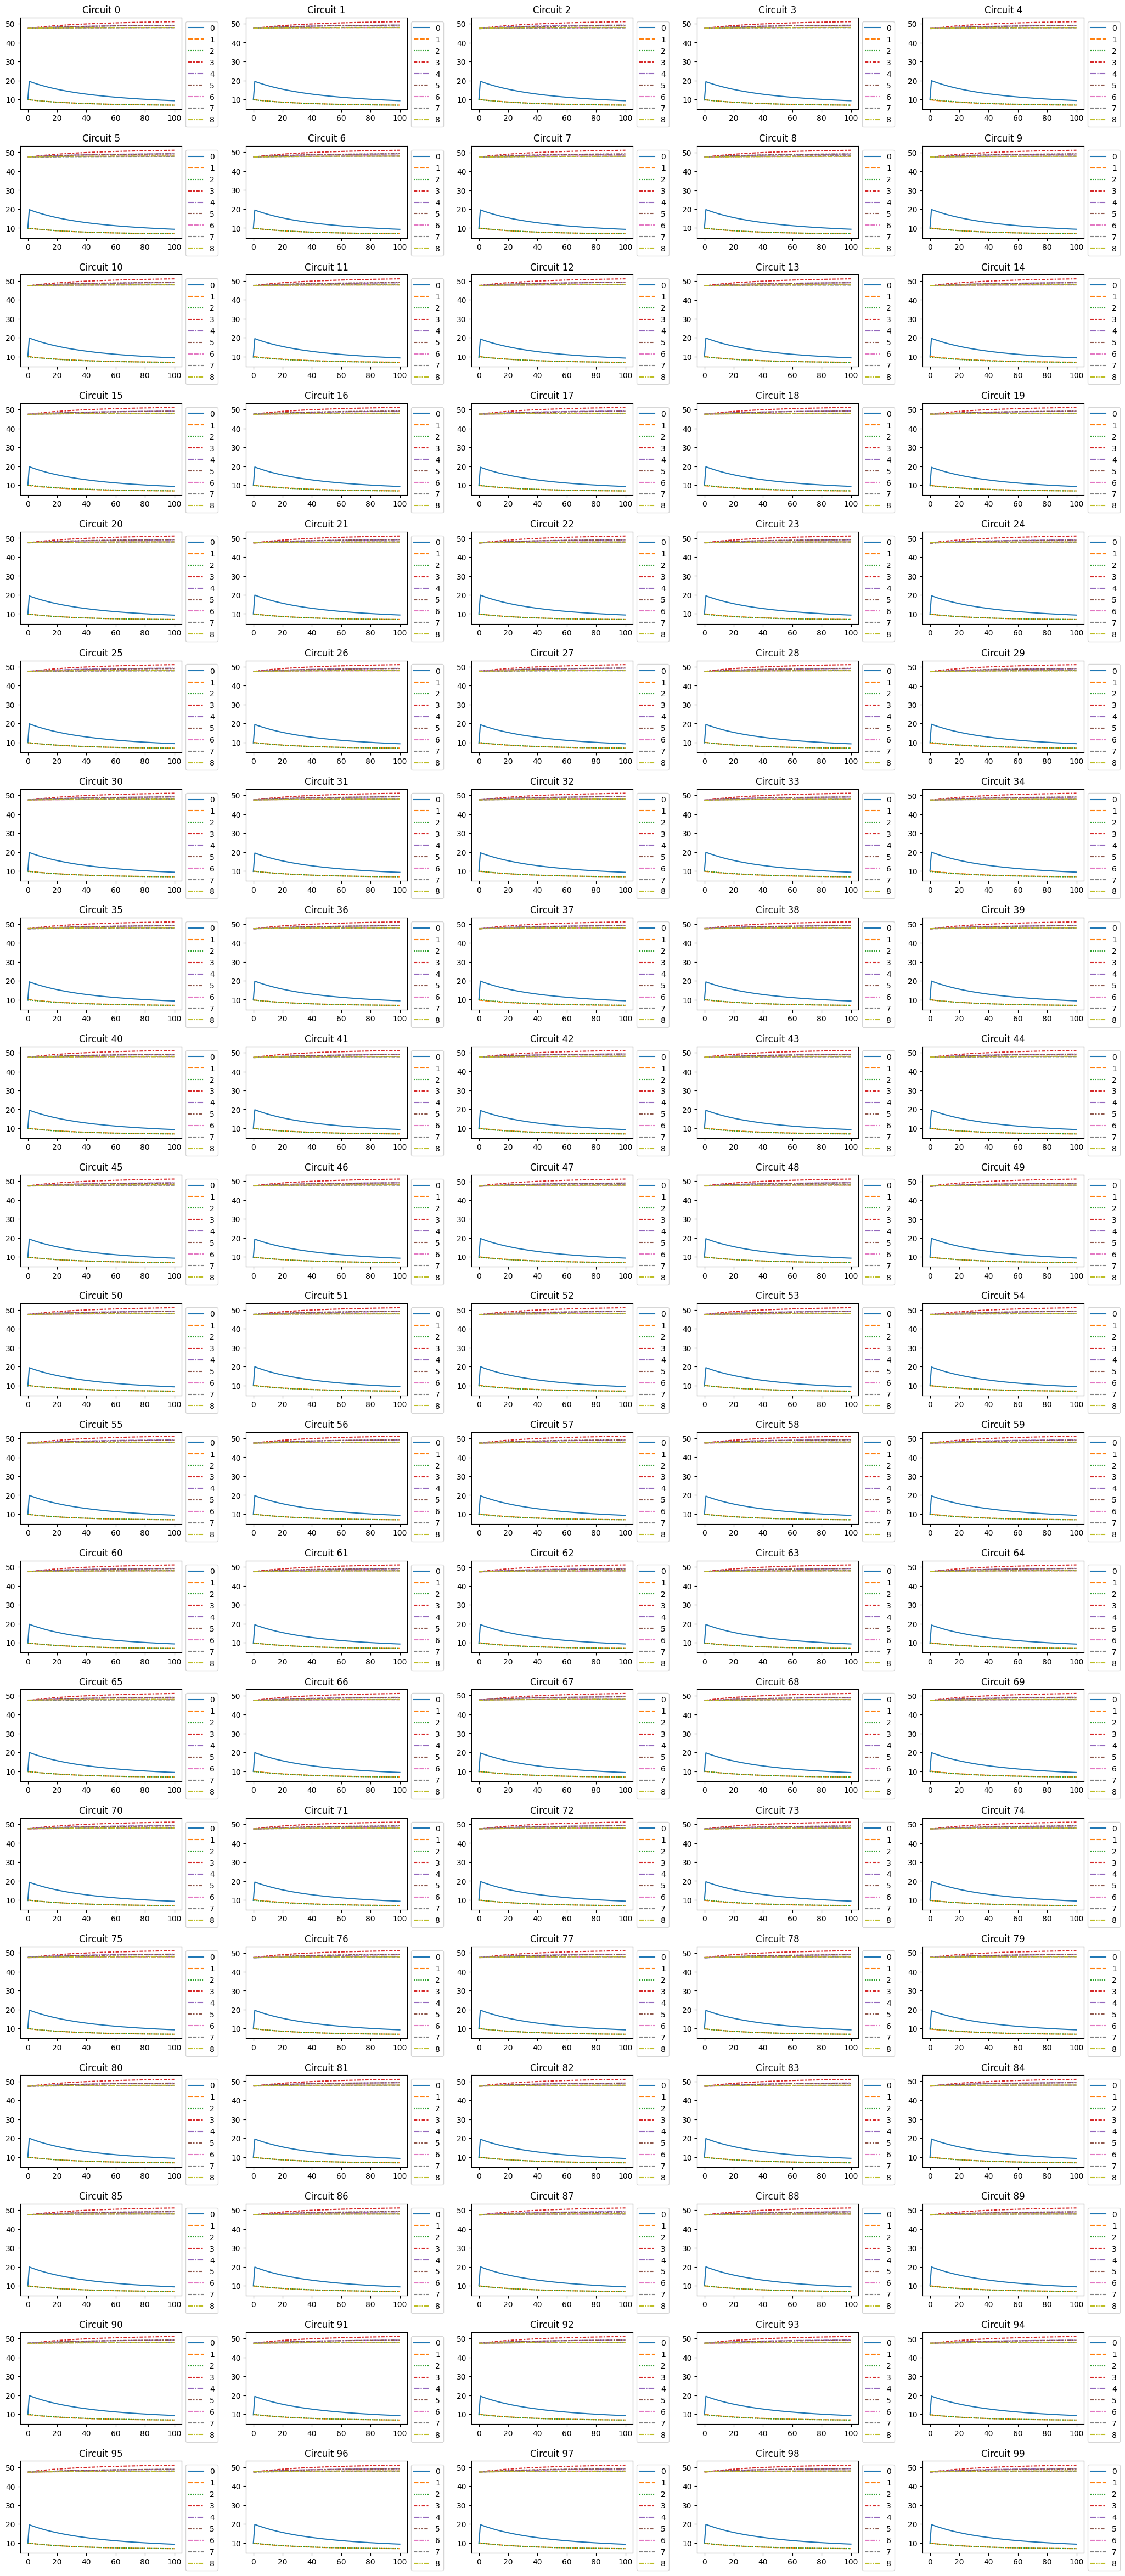

In [ ]:
# ys = jax.vmap(f_t)(k1 / all_eqconstants[-1], y0=y_perturbed)
ys = jax.vmap(sim_chain[0])(k1 / np.power(10, all_eqconstants[-1]), yp=y_perturbed, y0=y_steady[:, -1, :][:, None, :])
n_rows = n_circuits // 5 + (np.mod(n_circuits, 5) != 0)
n_cols = n_circuits // n_rows
fig = plt.figure(figsize=(5*n_cols, 3 * n_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for c, y in enumerate(ys):
    ax = plt.subplot(n_rows, n_cols, c+1)
    g = sns.lineplot(y, ax=ax)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f'Circuit {c}')

## Circuit param evolution

Text(0.5, 0.98, 'Change in circuit parameters across 20 epochs for 100 circuits')

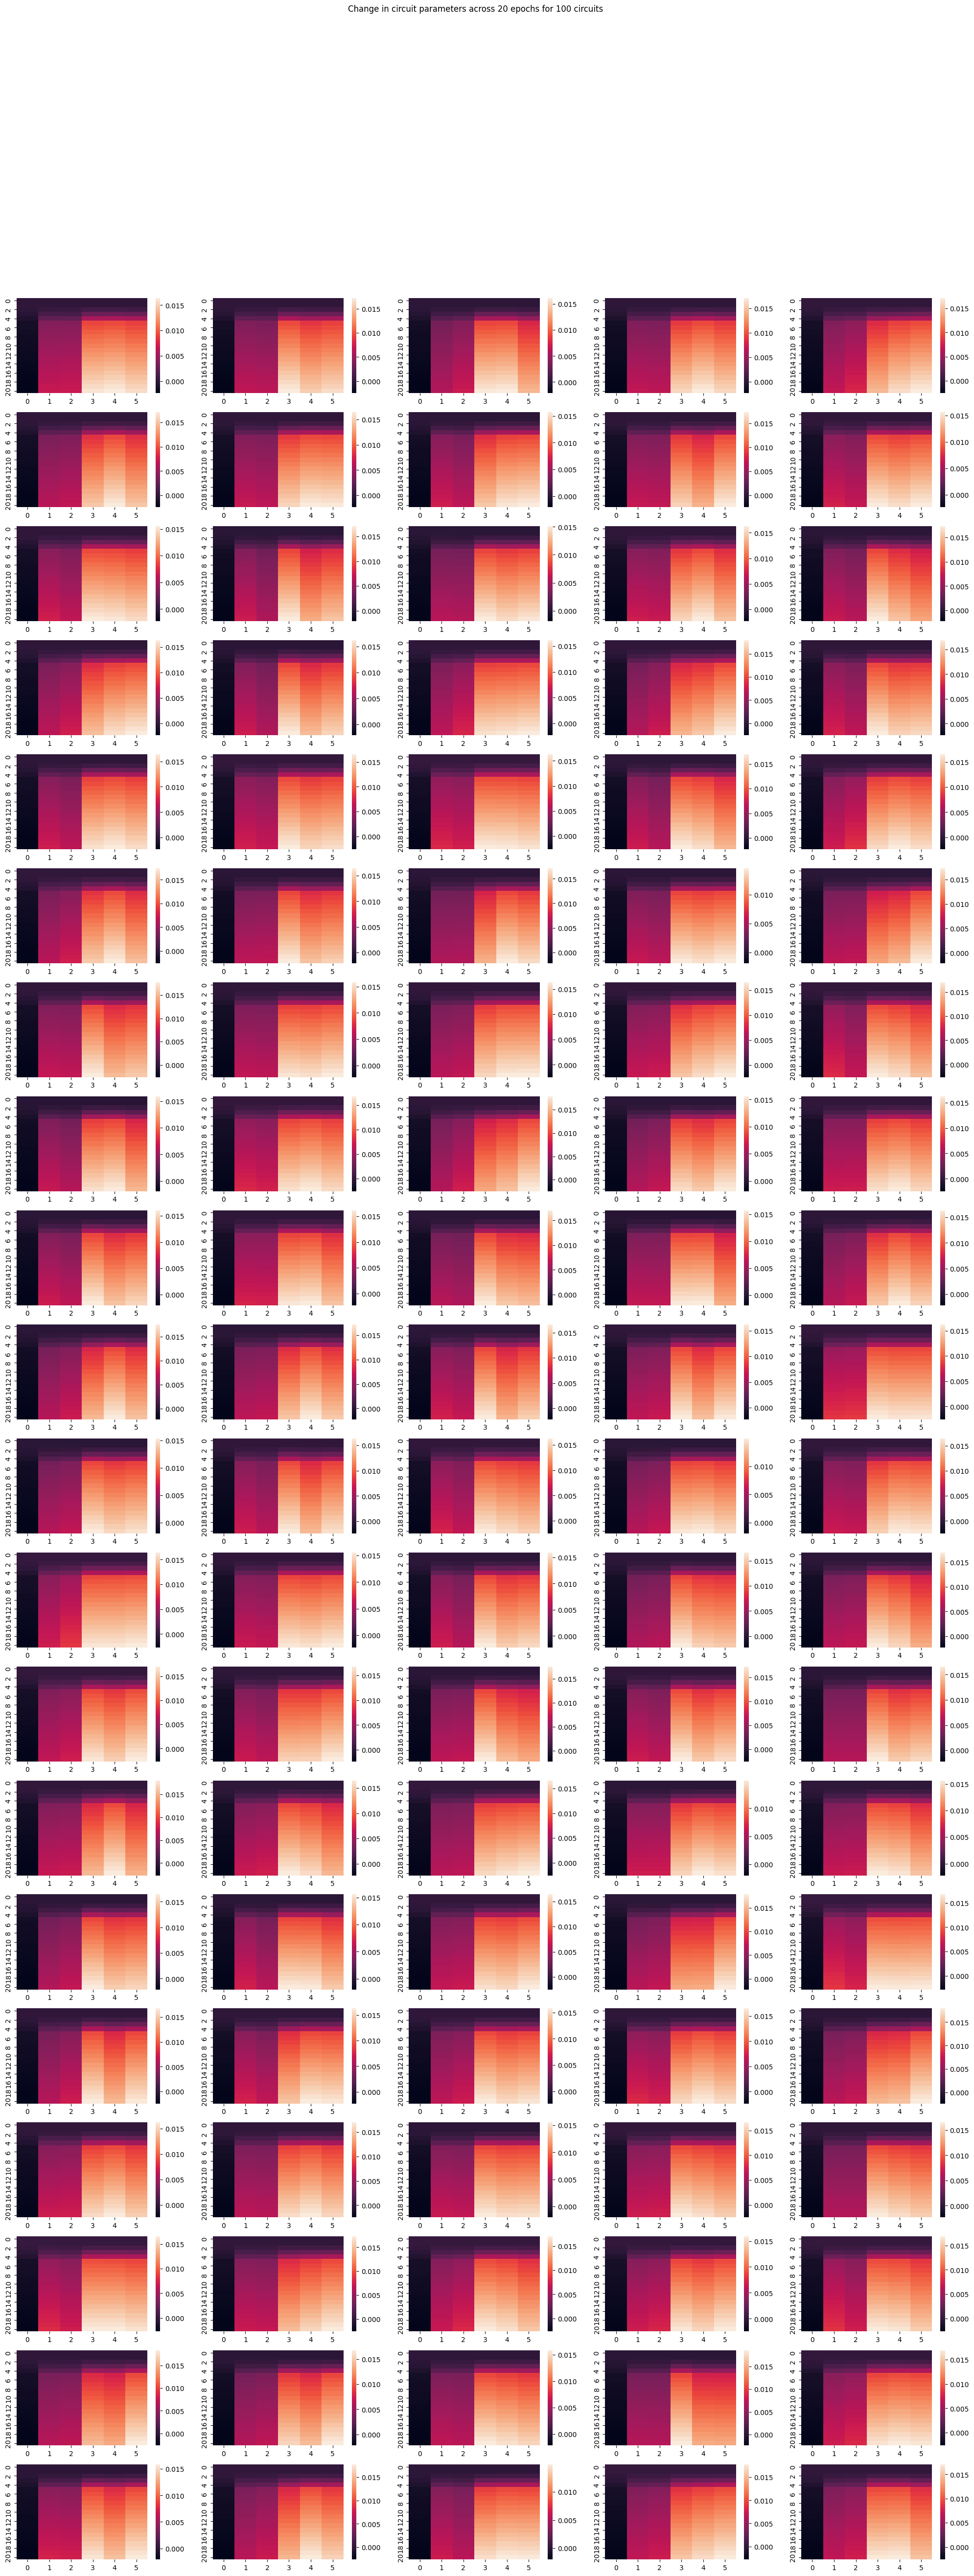

In [ ]:
n_rows = n_circuits // 5 + (np.mod(n_circuits, 5) != 0)
n_cols = n_circuits // n_rows
fig = plt.figure(figsize=(5*n_cols, 3 * n_rows))
for c in range(n_circuits):
    ax = plt.subplot(n_rows, n_cols, c+1)
    sns.heatmap(all_eqconstants[:, c, :] - all_eqconstants[0, c, :])
plt.suptitle(f'Change in circuit parameters across {epochs} epochs for {n_circuits} circuits')

Text(0.5, 0.98, 'Circuit parameters across 20 epochs for 100 circuits')

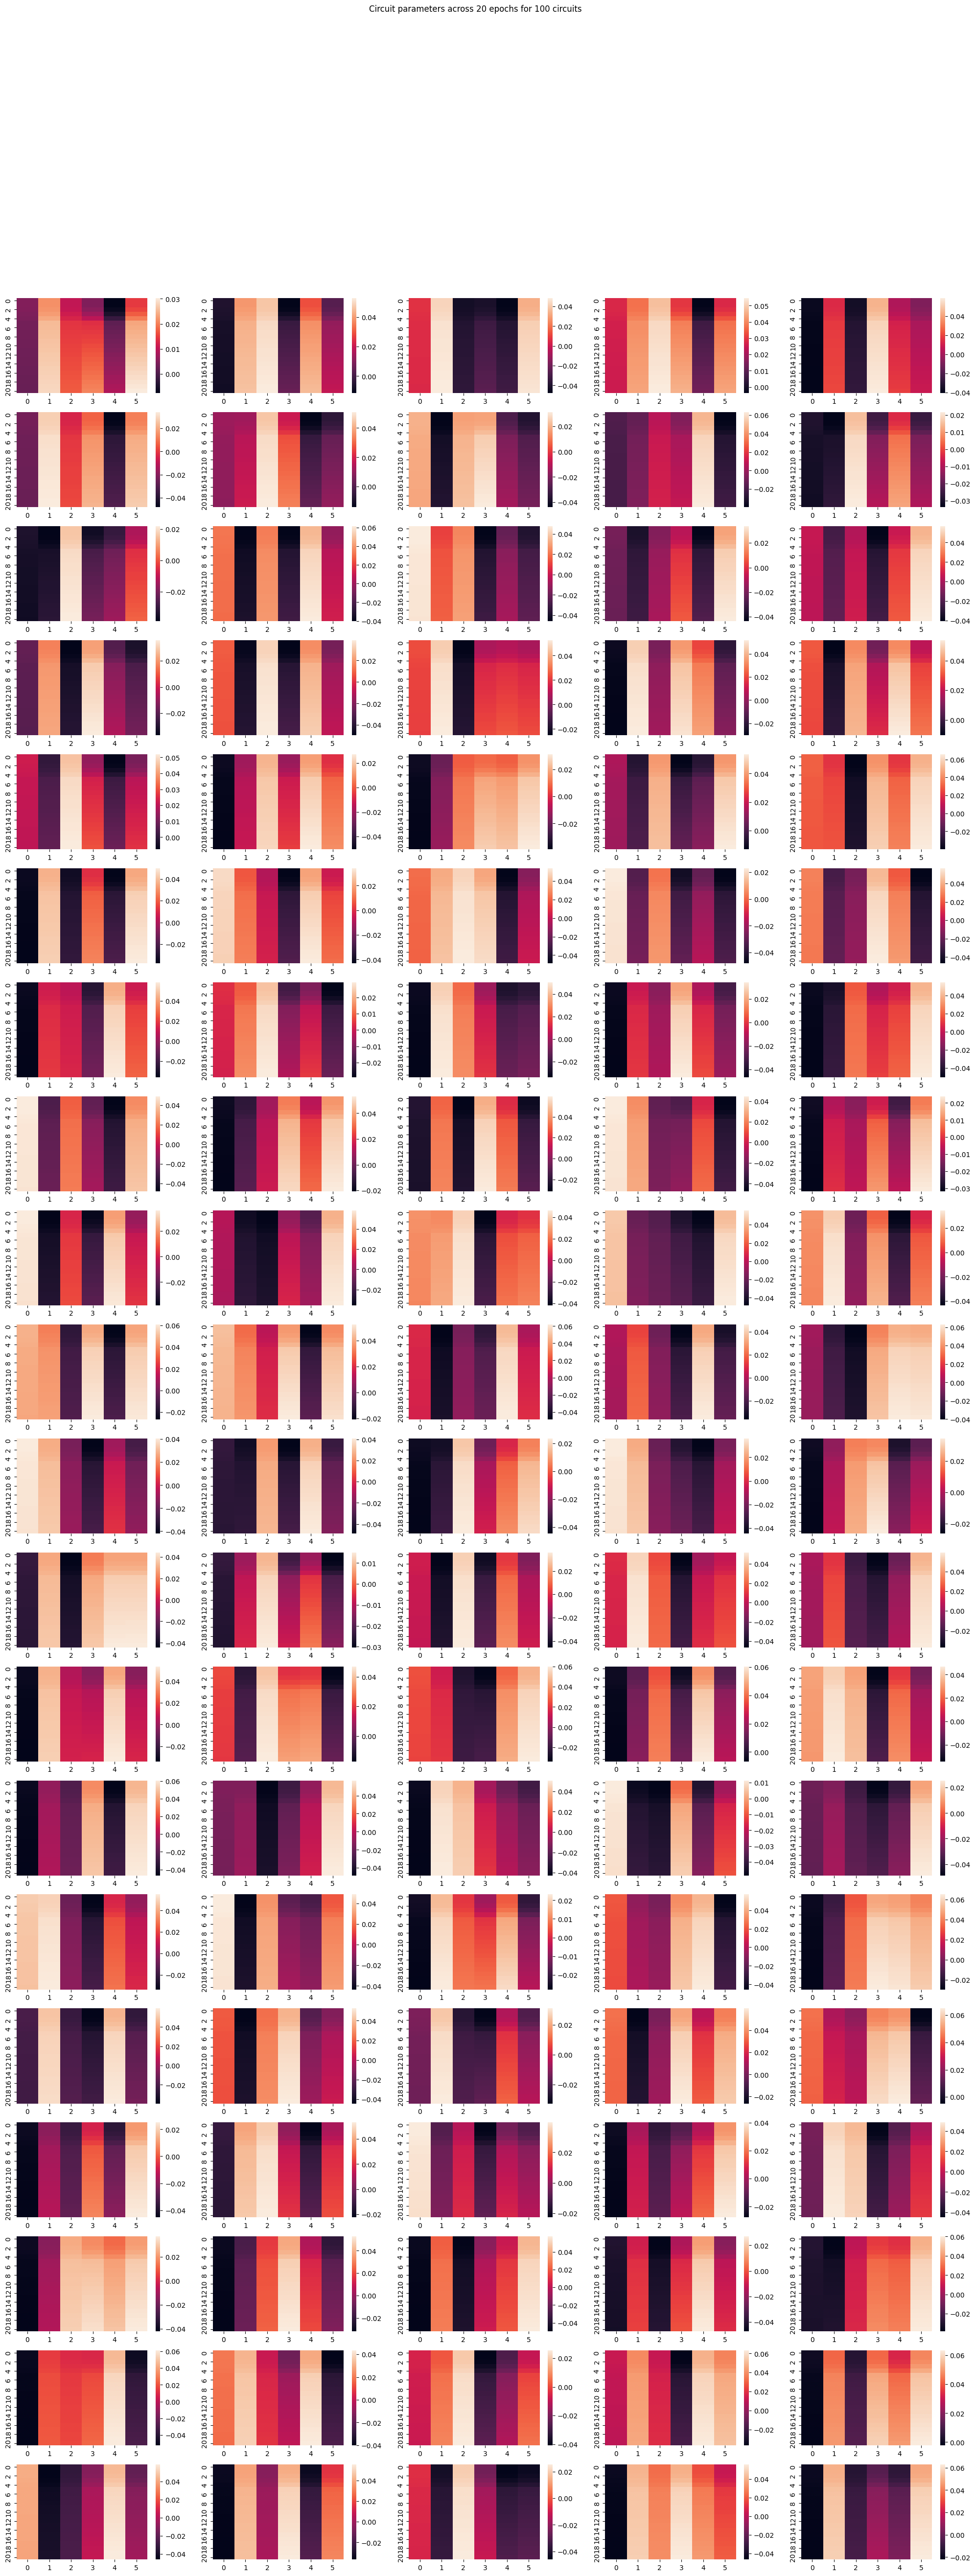

In [ ]:
n_rows = n_circuits // 5 + (np.mod(n_circuits, 5) != 0)
n_cols = n_circuits // n_rows
fig = plt.figure(figsize=(5*n_cols, 3 * n_rows))
for c in range(n_circuits):
    ax = plt.subplot(n_rows, n_cols, c+1)
    sns.heatmap(all_eqconstants[:, c, :]) # - all_eqconstants[0, c, :])
plt.suptitle(f'Circuit parameters across {epochs} epochs for {n_circuits} circuits')


Text(0.5, 0.98, 'Equilibrium constant across 20 epochs for 100 circuits')

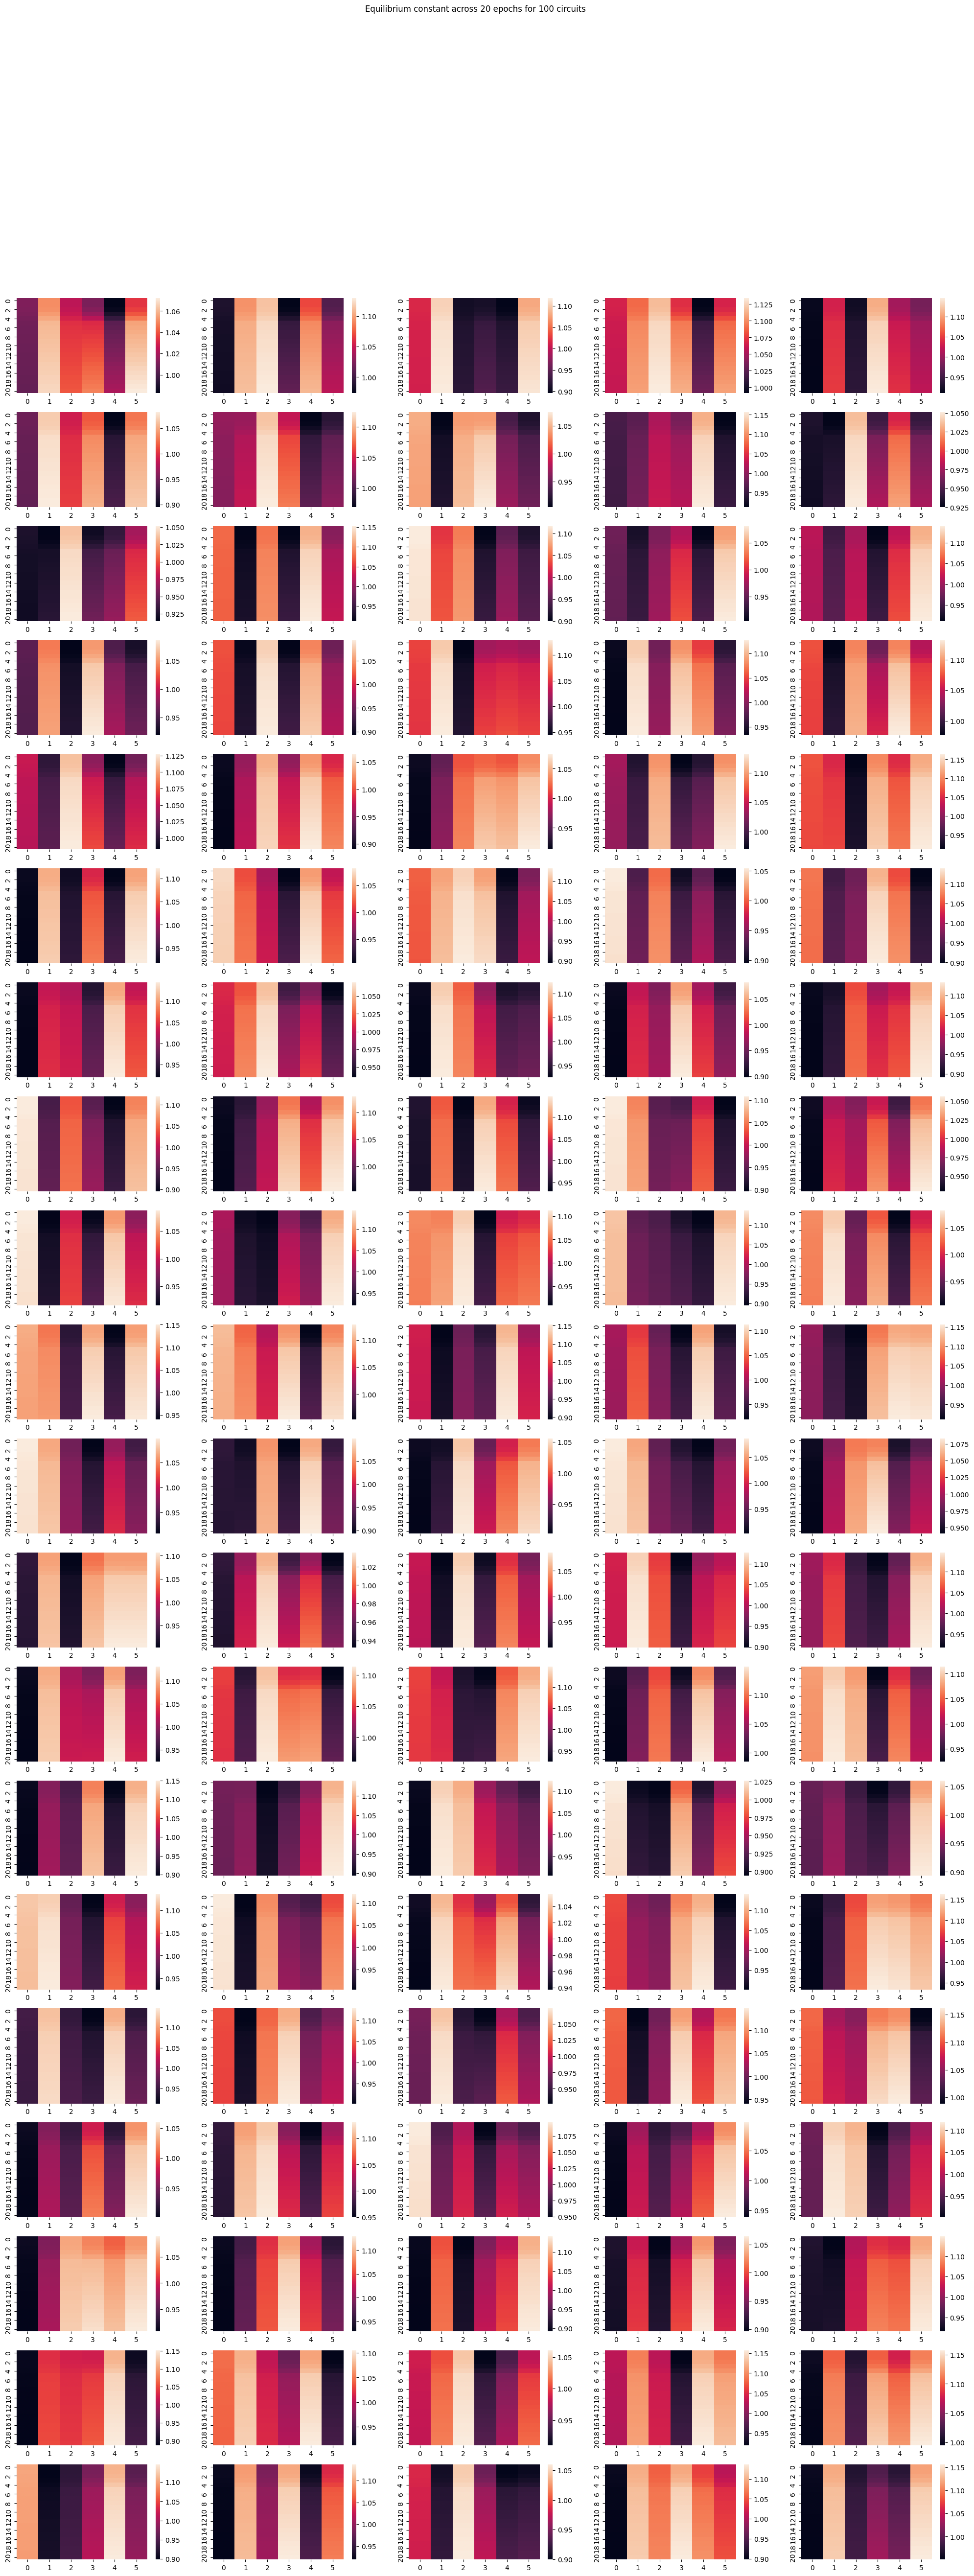

In [ ]:
fig = plt.figure(figsize=(5*n_cols, 3 * n_rows))
for c in range(n_circuits):
    ax = plt.subplot(n_rows, n_cols, c+1)
    sns.heatmap(np.power(10, all_eqconstants[:, c, :])) # - all_eqconstants[0, c, :])
plt.suptitle(f'Equilibrium constant across {epochs} epochs for {n_circuits} circuits')


## Costs

Text(50.722222222222214, 0.5, 'Epoch')

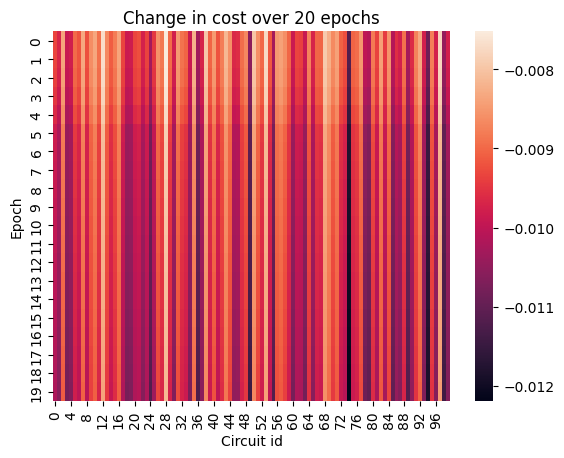

In [ ]:
sns.heatmap(cs)
plt.title(f'Change in cost over {epochs} epochs')
plt.xlabel('Circuit id')
plt.ylabel('Epoch')

# Unpacked scan (for loop)

In [ ]:
# cs = np.zeros([epochs, n_circuits])
# rs = np.zeros([epochs + 1, *reverse_rates.shape])
# rs[0] = reverse_rates
# inp = [reverse_rates, optimiser_state]
# for i, cr in enumerate(zip(cs, rs)):
#     if i == 1:
#         print(i)
#     inp, crs = f_scan(inp, cr)
#     fin_reverse_rates, optimiser_state = inp
#     cs[i] = np.array(crs[0])
#     rs[i+1] = crs[1]
#     if np.sum(np.isnan(rs[:, 3, :])) > 0:
#         print(rs)

In [ ]:
# fig = plt.figure(figsize=(5*n_circuits, 3))
# for c in range(n_circuits):
#     ax = plt.subplot(1, n_circuits, c+1)
#     sns.heatmap(np.log10(rs[1:, c, :]))